In [1]:
import time
now = time.time()

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_dataset = pd.read_csv('DataSets/DatasetsCreated/train_dataset.csv')
train_dataset.shape

(1053282, 50)

## Categorical Data

In [4]:
# categorical_features = ['Tag', 'Purchaser', 'Merchant_Popular']
# for feature in categorical_features:
#     train_dataset[feature] = pd.Categorical(train_dataset[feature])

# One Hot Encoding
# train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['Tag'], prefix='Tag',prefix_sep='_', drop_first=True,dummy_na=False)],axis=1)
# train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['DayOfWeek'], prefix='DayOfWeek',prefix_sep='_', drop_first=True,dummy_na=False)],axis=1)


In [5]:
train_dataset.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'Discount', 'Original_price',
       'Discounted_price', 'Rate', 'Tag', 'User_Released', 'User_Redeemed',
       'User_Ratio', 'User_Buys', 'Purchaser', 'UserMerchantCount', 'DayList',
       'Merchant_Redeemed', 'Merchant_Ratio', 'Merchant_AvgDistance',
       'Merchant_Popular', 'Merchant_AvgRate', 'AvgDailyUsers', 'VisitList',
       'UniqueUsersCount', 'MerchantRedemptionList', 'Coupon_Released',
       'Coupon_Redeemed', 'Coupon_Ratio', 'Duration', 'RedemptionList',
       'ReleasesCount', 'ImpDay', 'Weekend', 'DayOfWeek', 'Visits',
       'User_Merchant_Ratio', 'Merchant_User_Visit', 'DateTrack', 'First_day',
       'DayNum', 'LastUserVisit', 'LastRedemption', 'LastMerchantVisit',
       'LastMerchantRedemption', 'LastMerchantUserVisit', 'RedemptionDuration',
       'Target'],
      dtype='object')

## Final Features

In [6]:
remove_columns = ['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate','Discount','Date_received',
                  'Date','Count','RedemptionDuration','DayList','DateTrack','DayNum','First_day',
                  'RedemptionList','VisitList', 'Merchant_User_Visit', 'MerchantRedemptionList']
unimportant_features = ['DayOfWeek','Weekend','ImpDay','Merchant_Popular','Purchaser']
features = list(set(train_dataset.columns)-set(remove_columns)-set(['Target'])-set(unimportant_features))
print('Features to be included:'+str(len(features)))                  
print(features)

Features to be included:28
['Visits', 'LastMerchantUserVisit', 'User_Released', 'Coupon_Ratio', 'Merchant_Redeemed', 'User_Buys', 'Merchant_Ratio', 'UniqueUsersCount', 'AvgDailyUsers', 'LastRedemption', 'LastMerchantVisit', 'Tag', 'Duration', 'User_Ratio', 'User_Merchant_Ratio', 'Distance', 'Merchant_AvgRate', 'UserMerchantCount', 'Coupon_Released', 'Coupon_Redeemed', 'Merchant_AvgDistance', 'Discounted_price', 'User_Redeemed', 'Original_price', 'LastMerchantRedemption', 'Rate', 'LastUserVisit', 'ReleasesCount']


# Model

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import KFold

In [10]:
def save_model(model,X_test):
    #saving model
    from sklearn.externals import joblib 

    # Save the model as a pickle in a file 
    joblib.dump(model, 'Model/xgboost.pkl') 

    # Load the model from the file 
    clf_saved= joblib.load('Model/xgboost.pkl')  

    # Use the loaded model to make predictions 
    #predictions_saved = (clf_saved.predict_proba(X_test)[:,1]).tolist()
    

### XGBoost

In [11]:
def train_model(train_dataset):
    y = list(train_dataset['Target'])
    X = train_dataset[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#     clf = RandomForestClassifier(n_estimators=500, max_depth=10)
    clf = XGBClassifier(
     learning_rate =0.1,
     n_estimators=500,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=5,
     scale_pos_weight=1,
     seed=45,
     alpha=0.2)
    
    model = clf.fit(X_train, y_train)
    save_model(model,X_test)
    
    predictions = (model.predict_proba(X_test)[:,1]).tolist()
    predicted_values = (model.predict(X_test)).tolist()
    test_dataset = pd.merge(X_test, train_dataset[['User_id','Merchant_id','Date_received']], how='left',left_index=True,right_index=True)
    output = test_dataset[['User_id','Merchant_id','Date_received']]
    output['Probabilities'] = predictions
    ax = plot_importance(model)
    fig = ax.figure
    fig.set_size_inches(15, 9)
    plt.show()

    return predictions, output, y_test, model, predicted_values


/Users/mahimaarora/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


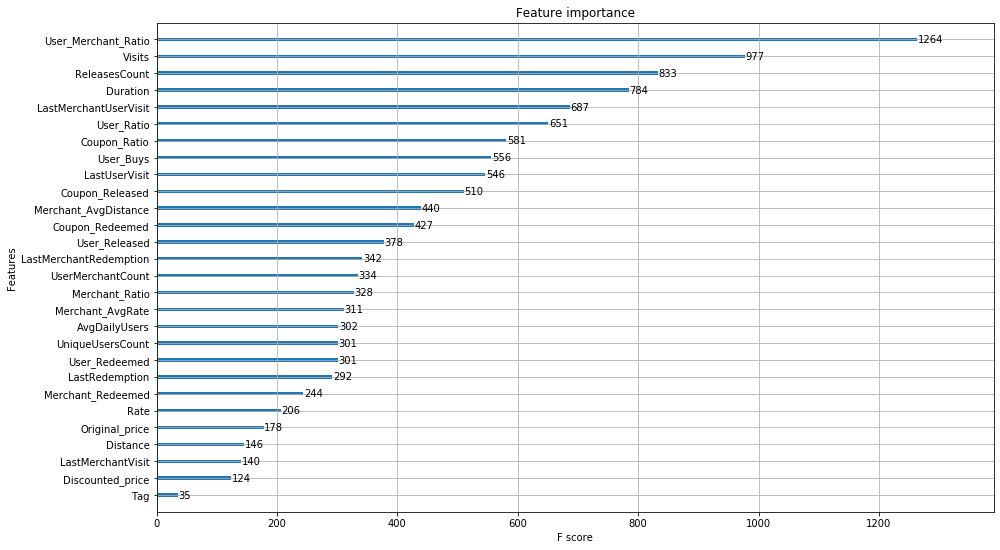

In [12]:
predictions,output,y_test,model,predicted_values= train_model(train_dataset)

In [13]:
# feature_importances = pd.DataFrame(model.feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=True)
# feature_importances.plot(kind='barh',figsize=(10,20))

In [14]:
def evaluate_model(predictions, predicted_values, y_test):
    roc_score = round(roc_auc_score(y_test, predictions), 3)

    print('ROC AUC Score of Probailities:  '+ str(roc_score))
    print('ROC AUC Curve')
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    auc = metrics.roc_auc_score(y_test, predictions)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    predicted_values = [1 if x>0.5 else 0 for x in predictions]
    print('______________________________________________________________________')
    print('\n The classification report for the model:')
    print(classification_report(y_test, predicted_values) )
    
    results = confusion_matrix(y_test, predicted_values) 
    print('______________________________________________________________________')
    print('\n The confusion matrix for the model:')
    print(results)
    print('______________________________________________________________________')
    

ROC AUC Score of Probailities:  0.992
ROC AUC Curve


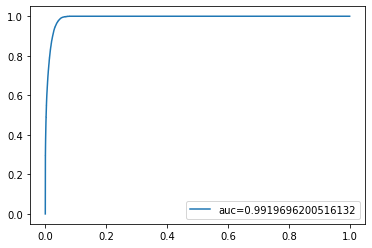

______________________________________________________________________

 The classification report for the model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    296891
           1       0.79      0.78      0.79     19094

    accuracy                           0.97    315985
   macro avg       0.89      0.88      0.89    315985
weighted avg       0.97      0.97      0.97    315985

______________________________________________________________________

 The confusion matrix for the model:
[[293011   3880]
 [  4233  14861]]
______________________________________________________________________


In [15]:
evaluate_model(predictions, predicted_values, y_test)

# Execution Time of this notebook

In [ ]:
later = time.time()
difference = later - now
print('Time taken for the execution of this notebook: '+str(round(difference/60,2))+' mins')